In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [ ]:
df = pd.read_excel('sentadilla_60.xlsx', sheet_name='SENT 60')

df_mod = df.copy()

# Ejes y fases a procesar
ejes = ['Y', 'X', 'Z']
fases = ['F1', 'F2', 'F3']
unidades = ['(%BW)', '(NEWTON)']

for fase in fases:
    for eje in ejes:
        for unidad in unidades:
            col_d = f"{fase}-VGRF{eje} D {unidad}"
            col_i = f"{fase}-VGRF{eje} I {unidad}"
            col_t = f"{fase}-VGRF{eje} T {unidad}"
            col_diff = f"{fase}-VGRF{eje}-DIFF {unidad}"

            if col_d in df_mod.columns and col_i in df_mod.columns and col_t in df_mod.columns:
                # Calcular la diferencia
                df_mod[col_diff] = np.abs(np.abs(df_mod[col_d]) - np.abs(df_mod[col_i]))

                # Reubicar la columna justo después de la columna T
                col_idx = df_mod.columns.get_loc(col_t) + 1
                cols = df_mod.columns.tolist()

                # Mover la columna al lugar correcto
                cols.insert(col_idx, cols.pop(cols.index(col_diff)))
                df_mod = df_mod[cols]

In [2]:
df_deep = pd.read_excel('sentadilla_90.xlsx', sheet_name='SENT 90')

df_mod_deep = df_deep.copy()

# Ejes y fases a procesar
ejes = ['Y', 'X', 'Z']
fases = ['F1', 'F2', 'F3']
unidades = ['(%BW)', '(NEWTON)']

for fase in fases:
    for eje in ejes:
        for unidad in unidades:
            col_d = f"{fase}-VGRF{eje} D {unidad}"
            col_i = f"{fase}-VGRF{eje} I {unidad}"
            col_t = f"{fase}-VGRF{eje} T {unidad}"
            col_diff = f"{fase}-VGRF{eje}-DIFF {unidad}"

            if col_d in df_mod_deep.columns and col_i in df_mod_deep.columns and col_t in df_mod_deep.columns:
                # Calcular la diferencia
                df_mod_deep[col_diff] = np.abs(np.abs(df_mod_deep[col_d]) - np.abs(df_mod_deep[col_i]))

                # Reubicar la columna justo después de la columna T
                col_idx = df_mod_deep.columns.get_loc(col_t) + 1
                cols = df_mod_deep.columns.tolist()

                # Mover la columna al lugar correcto
                cols.insert(col_idx, cols.pop(cols.index(col_diff)))
                df_mod_deep = df_mod_deep[cols]

In [23]:
df_stas= df_mod.describe().loc[['mean','std']].T
df_stas['cv'] = (df_stas['std'] / np.abs(df_stas['mean'])).round(2)
fases = ['F1', 'F2', 'F3']
df_stas = df_stas.T
df_stas.drop(columns=[f"{fase}TIME" for fase in fases], inplace=True)
df_stas = df_stas.T
df_stas['media(ds)'] = df_stas['mean'].round(3).astype(str) + ' (±' + df_stas['std'].round(2).astype(str) + ')'
df_stas

,mean,std,cv,media(ds)
participante,15.500000,8.803408,0.57,15.5 (±8.8)
F1-RODSAGITAL D,5.046433,3.508227,0.70,5.046 (±3.51)
F1-RODSAGITAL I,5.516667,4.312963,0.78,5.517 (±4.31)
F1-VGRFY D (%BW),0.502500,0.081818,0.16,0.503 (±0.08)
F1-VGRFY I (%BW),0.509367,0.080989,0.16,0.509 (±0.08)
...,...,...,...,...
F3-VGRFZ-DIFF (%BW),0.006167,0.005663,0.92,0.006 (±0.01)
F3-VGRFZ D (NEWTON),-38.742567,12.829653,0.33,-38.743 (±12.83)
F3-VGRFZ I (NEWTON),40.338667,12.907177,0.32,40.339 (±12.91)
F3-VGRFZ T (NEWTON),1.596000,4.748685,2.98,1.596 (±4.75)


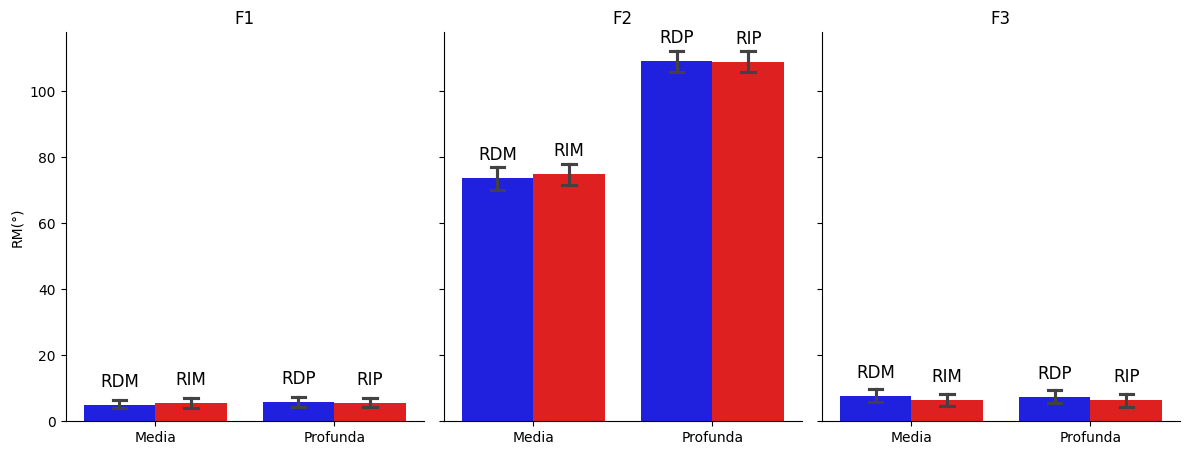

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- función para pasar de wide → long ----------
def long_fase(fase: str) -> pd.DataFrame:
    cols = [f'{fase}-RODSAGITAL D', f'{fase}-RODSAGITAL I']

    df_media = df_mod[cols].melt(value_vars=cols, var_name='FasePierna', value_name='Ángulo promedio')
    df_media['Condicion'] = 'Media'

    df_prof = df_mod_deep[cols].melt(value_vars=cols, var_name='FasePierna', value_name='Ángulo promedio')
    df_prof['Condicion'] = 'Profunda'

    df = pd.concat([df_media, df_prof], ignore_index=True)
    df['Pierna'] = df['FasePierna'].str.contains(' D').map({True: 'D', False: 'I'})
    df['Fase'] = fase
    return df

# ---------- dataframe largo ----------
df_plot = pd.concat([long_fase(f) for f in ('F1', 'F2', 'F3')], ignore_index=True)

# ---------- colores por pierna ----------
palette = {'D': '#0000FF', 'I': '#FF0000'}

# ---------- etiquetas personalizadas ----------
etiquetas_barras = ['RDM', 'RDP', 'RIM', 'RIP']   # Orden esperado por condición y pierna

# ---------- figura ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for fase, ax in zip(('F1', 'F2', 'F3'), axes):
    # subset por fase
    data_fase = df_plot[df_plot['Fase'] == fase]

    # ordenar manualmente para mantener el orden esperado
    orden = ['Media', 'Profunda']
    hue_order = ['D', 'I']

    barplot = sns.barplot(
        data=data_fase,
        x='Condicion', y='Ángulo promedio', hue='Pierna',
        palette=palette, errorbar=('ci', 95), capsize=.15,
        ax=ax, edgecolor=None, linewidth=0,
        order=orden, hue_order=hue_order
    )

    # Título y estilo
    ax.set_title(fase)
    ax.set_xlabel('')
    if ax is axes[0]:
        ax.set_ylabel('RM(°)')
    else:
        ax.set_ylabel('')
    sns.despine(ax=ax)
    ax.get_legend().remove() 
    # Añadir etiquetas personalizadas encima de cada barra
    for container, etiquetas in zip(ax.containers, [etiquetas_barras[:2], etiquetas_barras[2:]]):
        ax.bar_label(container, labels=etiquetas, padding=10, fontsize=12)

# ---------- título global ----------

fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('images_graficas/graficas_RM60-90.svg', format='svg')
plt.show()



In [24]:
import re

# ---------- utilidades ----------
def parse_val_sd(texto):
    """
    Extrae media y desviación estándar de un string tipo '0.51 (±0.10)'
    """
    m = re.match(r'\s*([+-]?\d+(?:\.\d+)?)\s*\(±\s*([+-]?\d+(?:\.\d+)?)\s*\)', str(texto))
    return (float(m.group(1)), float(m.group(2))) if m else (np.nan, np.nan)

def fmt(mean, sd, dec=2):
    """Devuelve 'media (±sd)' con n decimales."""
    return f"{mean:.{dec}f} (±{sd:.{dec}f})"

def fmt_cv(cv):               # cv en fracción → porcentaje
    return f"{cv*100:.2f}%"

# ---------- parámetros ----------
fases        = ['F1', 'F2', 'F3']
ejes_cod     = {'VGRFY': 'Vertical', 'VGRFX': 'Anteroposterior', 'VGRFZ': 'Medio-lateral'}
piernas      = {'D': 'RD', 'I': 'RI'}
unidades_map = {'(%BW)': 'BW', '(NEWTON)': 'N'}

# ---------- generación ----------
filas = []
for fase in fases:
    # rodillas en sagital
    rd_rod = df_stas.loc[f"{fase}-RODSAGITAL D", 'media(ds)']
    ri_rod = df_stas.loc[f"{fase}-RODSAGITAL I", 'media(ds)']

    # recorre cada eje
    for cod_eje, nombre_eje in ejes_cod.items():
        # -------------------- BW y N --------------------
        for sufijo, etiqueta in unidades_map.items():
            # valores por pierna
            rd_idx = f"{fase}-{cod_eje} D {sufijo}"
            ri_idx = f"{fase}-{cod_eje} I {sufijo}"
            

            rd_val = df_stas.loc[rd_idx, 'media(ds)'] if rd_idx in df_stas.index else None
            ri_val = df_stas.loc[ri_idx, 'media(ds)'] if ri_idx in df_stas.index else None

            # calcula total y diferencia si faltan
            # if rd_val and ri_val:
            #     m_rd, s_rd = parse_val_sd(rd_val)
            #     m_ri, s_ri = parse_val_sd(ri_val)

            #     if not tot_val:
            #         tot_val = fmt(m_rd + m_ri, (s_rd**2 + s_ri**2) ** 0.5)
            #     if not diff_val:
            #         diff_val = fmt(abs(m_rd - m_ri), (s_rd**2 + s_ri**2) ** 0.5)

            # ---------- fila BW / N ----------
            filas.append({
                'FASE': fase,
                'RD': rd_rod,
                'RI': ri_rod,
                'EJE': nombre_eje,
                'MÉTRICA': etiqueta,
                'RD_GR': rd_val,
                'RI_GR': ri_val,
            })

            # ---------- fila CV ----------
            rd_cv = df_stas.loc[rd_idx, 'cv'] if rd_idx in df_stas.index else np.nan
            ri_cv = df_stas.loc[ri_idx, 'cv'] if ri_idx in df_stas.index else np.nan
            filas.append({
                'FASE': '',
                'RD': '',
                'RI': '',
                'EJE': '',
                'MÉTRICA': 'CV',
                'RD_GR': fmt_cv(rd_cv) if not np.isnan(rd_cv) else '',
                'RI_GR': fmt_cv(ri_cv) if not np.isnan(ri_cv) else '',
            })

# ---------- DataFrame final ----------
cols = ['FASE', 'RD', 'RI', 'EJE', 'MÉTRICA',
        'RD_GR', 'RI_GR']
formatted_df_3 = pd.DataFrame(filas, columns=cols)

# opcional: elimina filas con métricas vacías si fuera necesario
formatted_df_3 = formatted_df_3.dropna(subset=['RD_GR', 'RI_GR'], how='all').reset_index(drop=True)
formatted_df_3 

,FASE,RD,RI,EJE,MÉTRICA,RD_GR,RI_GR
0,F1,5.046 (±3.51),5.517 (±4.31),Vertical,BW,0.503 (±0.08),0.509 (±0.08)
1,,,,,CV,16.00%,16.00%
2,F1,5.046 (±3.51),5.517 (±4.31),Vertical,N,295.933 (±55.48),300.264 (±56.09)
3,,,,,CV,19.00%,19.00%
4,F1,5.046 (±3.51),5.517 (±4.31),Anteroposterior,BW,-0.005 (±0.01),-0.007 (±0.01)
5,,,,,CV,150.00%,137.00%
6,F1,5.046 (±3.51),5.517 (±4.31),Anteroposterior,N,-3.049 (±4.5),-4.341 (±5.81)
7,,,,,CV,148.00%,134.00%
8,F1,5.046 (±3.51),5.517 (±4.31),Medio-lateral,BW,-0.063 (±0.02),0.074 (±0.02)
9,,,,,CV,33.00%,33.00%


In [25]:
with pd.ExcelWriter('sentadilla_60.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    formatted_df_3.to_excel(writer, sheet_name='Tabla v5', index=True)

In [2]:
from scipy.io import loadmat

data = loadmat("datos_filtrados_todos.mat")

# Ver las claves del diccionario
print(data.keys())

# Acceder a alguna variable


dict_keys(['__header__', '__version__', '__globals__', 'estructuraGeneral'])


In [3]:
estructura = data['estructuraGeneral']
print(estructura)

[[(array([[(array([[ 4.29998130e+00, -4.90587805e+01,  1.03943504e+03, ...,
                  -5.00425020e-01,  5.78788300e-01,  3.63404140e-01],
                 [ 4.31664790e+00, -5.61116191e+01,  1.06911952e+03, ...,
                  -5.15041700e-01,  5.68721660e-01,  3.80525180e-01],
                 [ 4.33331450e+00, -6.33229244e+01,  1.09276431e+03, ...,
                  -5.29168230e-01,  5.59008690e-01,  3.98782230e-01],
                 ...,
                 [ 1.36166107e+01,  4.82202870e+01,  5.99535519e+02, ...,
                  -3.34956710e-01,  7.88057450e-01,  3.09400090e-01],
                 [ 1.36332773e+01,  5.03212127e+01,  6.01712940e+02, ...,
                  -3.36888870e-01,  7.94202100e-01,  3.14870550e-01],
                 [ 1.36499439e+01,  5.19598352e+01,  5.94082972e+02, ...,
                  -3.38350020e-01,  7.98806180e-01,  3.19281860e-01]],
                shape=(562, 25)), array([[array(['time'], dtype='<U4'),
                  array(['walker_knee_r

In [4]:
print(type(estructura))                     
print(estructura.dtype)                     
print(estructura['PART12'].dtype)
print(estructura['PART12'][0, 0].dtype)          
print(estructura['PART12'][0, 0]['datos'].dtype)      
print(estructura['PART12'][0, 0]['nombresColumnas'][0, 0])

<class 'numpy.ndarray'>
[('PART12', 'O'), ('PART14', 'O'), ('PART20', 'O'), ('PART22', 'O'), ('PART24', 'O'), ('PART5', 'O')]
object
[('datos', 'O'), ('nombresColumnas', 'O')]
object
[[array(['time'], dtype='<U4')
  array(['walker_knee_r_on_femur_r_in_tibia_r_fx'], dtype='<U38')
  array(['walker_knee_r_on_femur_r_in_tibia_r_fy'], dtype='<U38')
  array(['walker_knee_r_on_femur_r_in_tibia_r_fz'], dtype='<U38')
  array(['walker_knee_r_on_femur_r_in_tibia_r_mx'], dtype='<U38')
  array(['walker_knee_r_on_femur_r_in_tibia_r_my'], dtype='<U38')
  array(['walker_knee_r_on_femur_r_in_tibia_r_mz'], dtype='<U38')
  array(['walker_knee_l_on_femur_l_in_tibia_l_fx'], dtype='<U38')
  array(['walker_knee_l_on_femur_l_in_tibia_l_fy'], dtype='<U38')
  array(['walker_knee_l_on_femur_l_in_tibia_l_fz'], dtype='<U38')
  array(['walker_knee_l_on_femur_l_in_tibia_l_mx'], dtype='<U38')
  array(['walker_knee_l_on_femur_l_in_tibia_l_my'], dtype='<U38')
  array(['walker_knee_l_on_femur_l_in_tibia_l_mz'], dtype='<

In [5]:
def estructura_df(participante:str):
    part = data['estructuraGeneral'][participante][0, 0]

    # Extraer datos y nombres de columnas
    datos = part['datos'][0, 0]         # matriz de tamaño (n, m)
    nombres_raw = part['nombresColumnas'][0, 0]  # array de arrays tipo [['time'], ['col1'], ...]

    # Convertir a strings simples
    nombres_columnas = [nombre[0] for nombre in nombres_raw[0]]

    # Crear el DataFrame
    df = pd.DataFrame(datos, columns=nombres_columnas)

    # Mostrar resumen
    return df



In [6]:
def rms_movil(x, ventana=70):
    x_cuad = x**2
    kernel = np.ones(ventana)/ventana
    return np.sqrt(np.convolve(x_cuad, kernel, mode='same'))

def tendencia(time,signal,grado = 12):
    x = time
    coef = np.polyfit(time, signal, grado)          # Encuentra los coeficientes del polinomio
    polinomio = np.poly1d(coef)             # Crea el polinomio
    x_fit = np.linspace(time.min(), time.max(), 100)
    y_fit = polinomio(x_fit)   
    return x_fit,y_fit

In [20]:
# k = [j for ]
print(estructura.dtype.names) 

('PART12', 'PART14', 'PART20', 'PART22', 'PART24', 'PART5')


In [10]:
from scipy.stats import zscore
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
def filter_picks_savgol(data:pd.Series):
    '''
    Filtra una columna de datos eliminando outliers (z-score > 3) y aplica suavizado Savitzky-Golay.
    data: pd.Series de la fuerza a filtrar.
    '''

    z = zscore(data)
    yx_cleaned = data.copy()
    yx_cleaned[np.abs(z) > 3] = np.mean(data)  # Elimina valores con z-score mayor a 3
    return savgol_filter(yx_cleaned, window_length=95, polyorder=3)
    

In [21]:

with pd.ExcelWriter('sentadilla_90_filtrado_todos.xlsx', engine='openpyxl') as writer:
    for part in estructura.dtype.names:
        df = estructura_df(part)
        df_filtrado = df.copy()
        columnas_a_filtrar = df.columns[1:]  # Excluye la primera columna (tiempo)
        for col in columnas_a_filtrar:
            df_filtrado[col] = filter_picks_savgol(df[col])
        # Guarda cada DataFrame en una hoja diferente
        df_filtrado.to_excel(writer, sheet_name=str(part), index=False)

In [19]:
df_filtrado.to_excel('sentadilla_90_filtrado.xlsx', index =False)

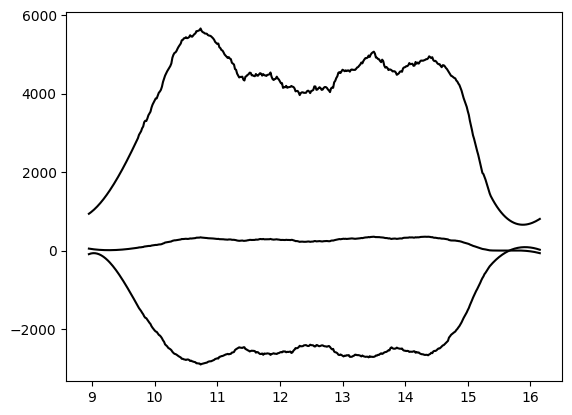

In [18]:
x = df_filtrado['time']
y = df_filtrado['walker_knee_r_on_femur_r_in_tibia_r_fx']
y2 = df_filtrado['walker_knee_r_on_femur_r_in_tibia_r_fy']
y3 = df_filtrado['walker_knee_r_on_femur_r_in_tibia_r_fz']

plt.plot(x, y, label='Fx sin filtrar', color='black')
plt.plot(x, y2, label='Fy sin filtrar', color='black')
plt.plot(x, y3, label='Fz sin filtrar', color='black')

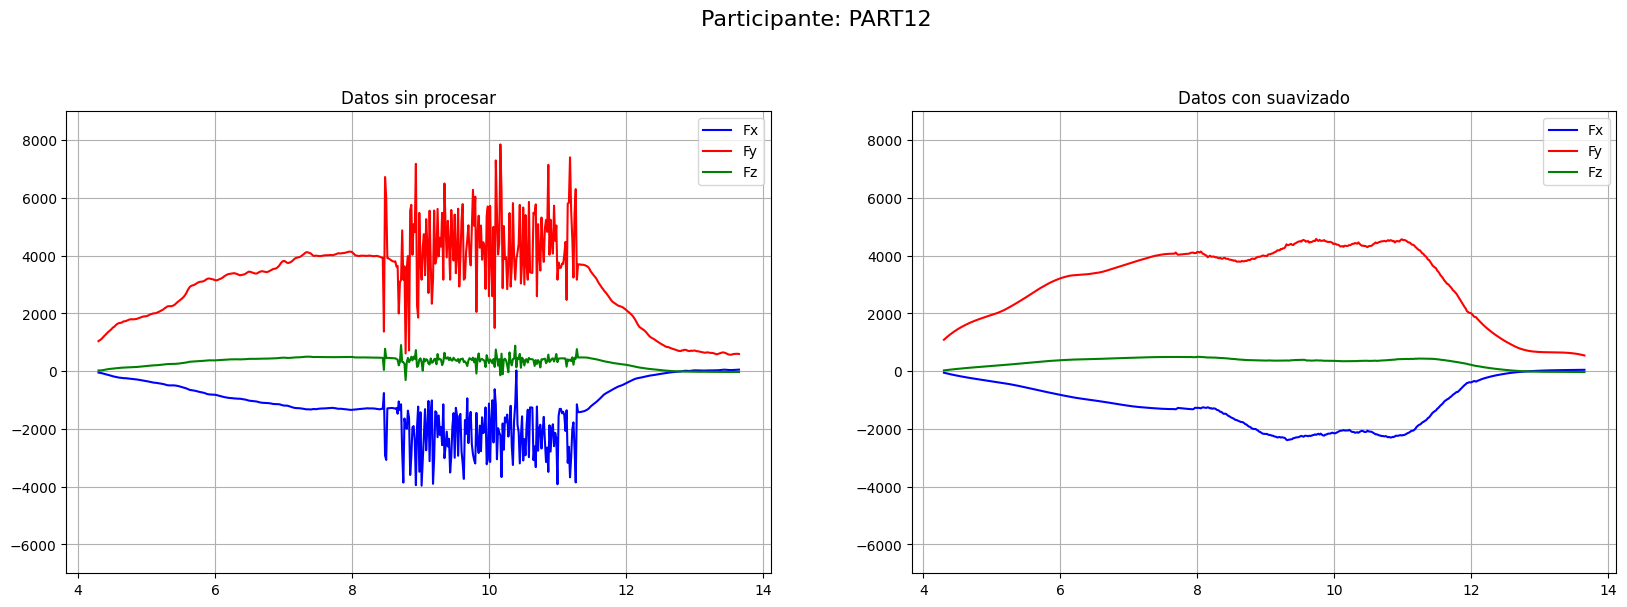

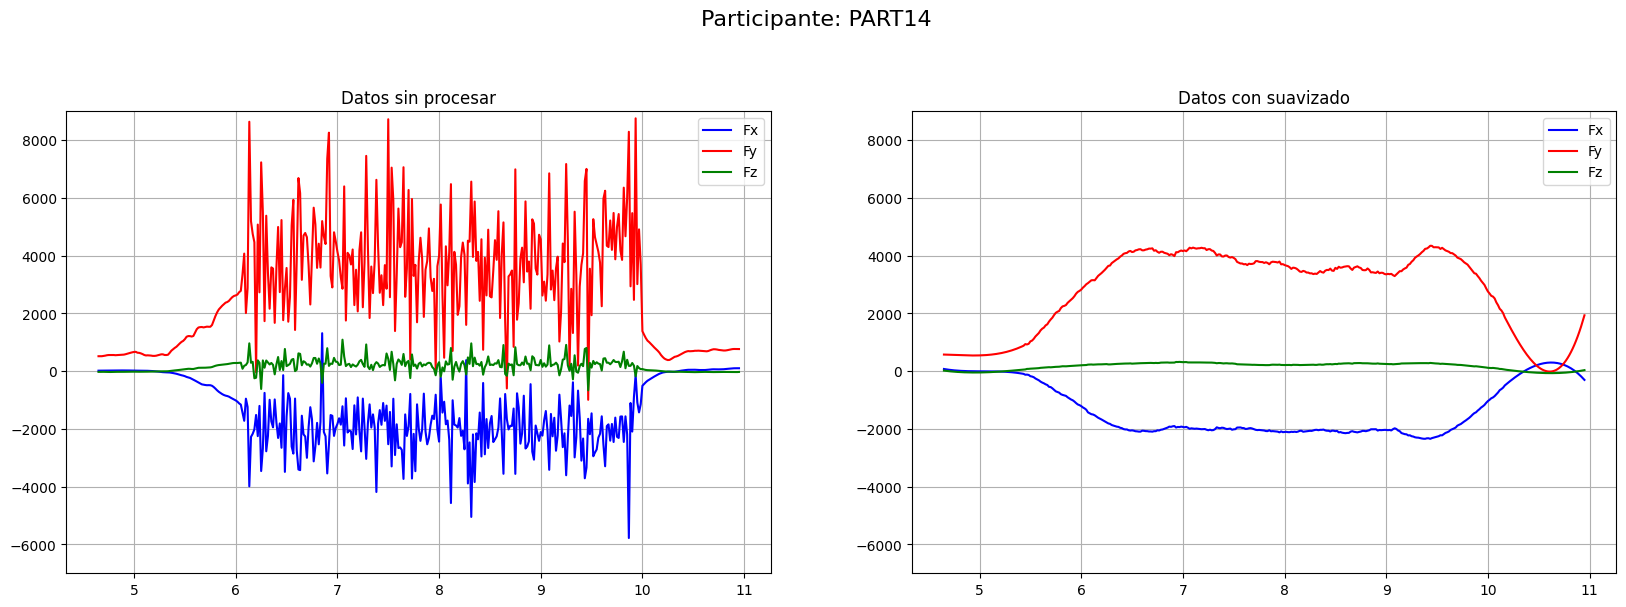

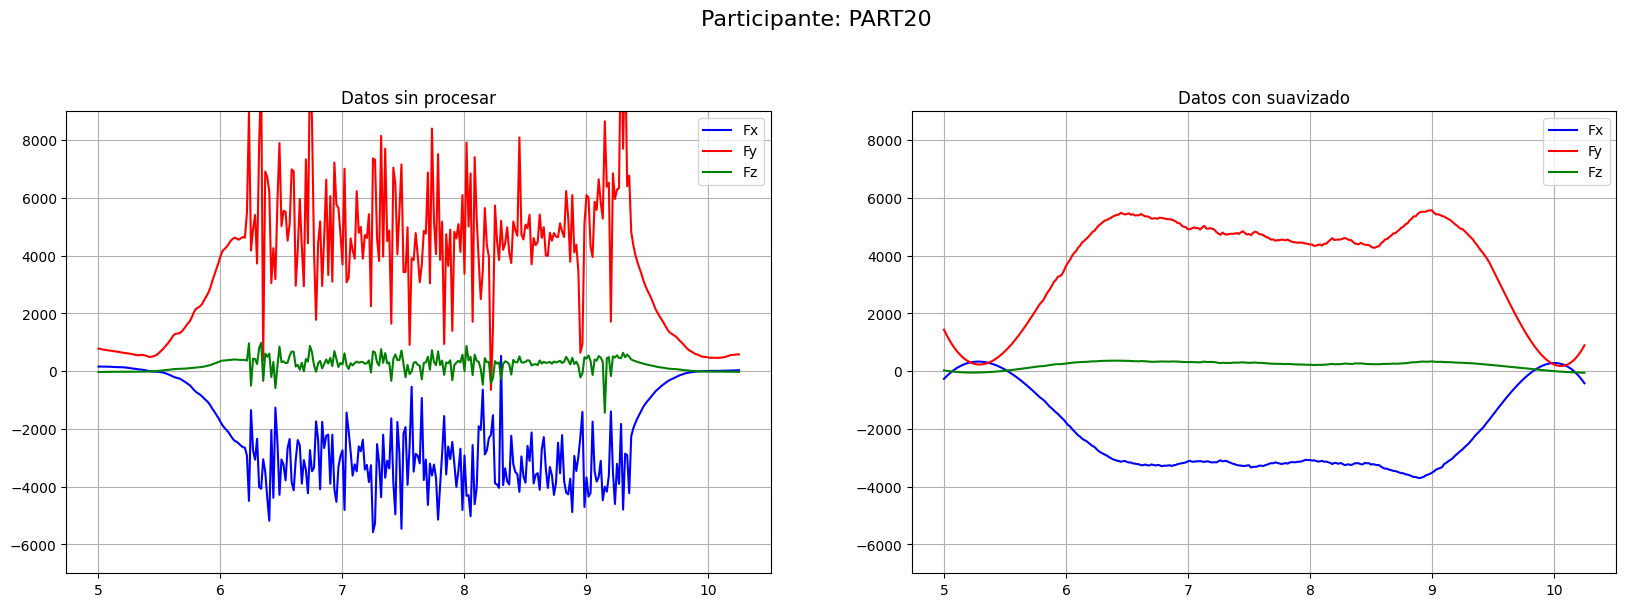

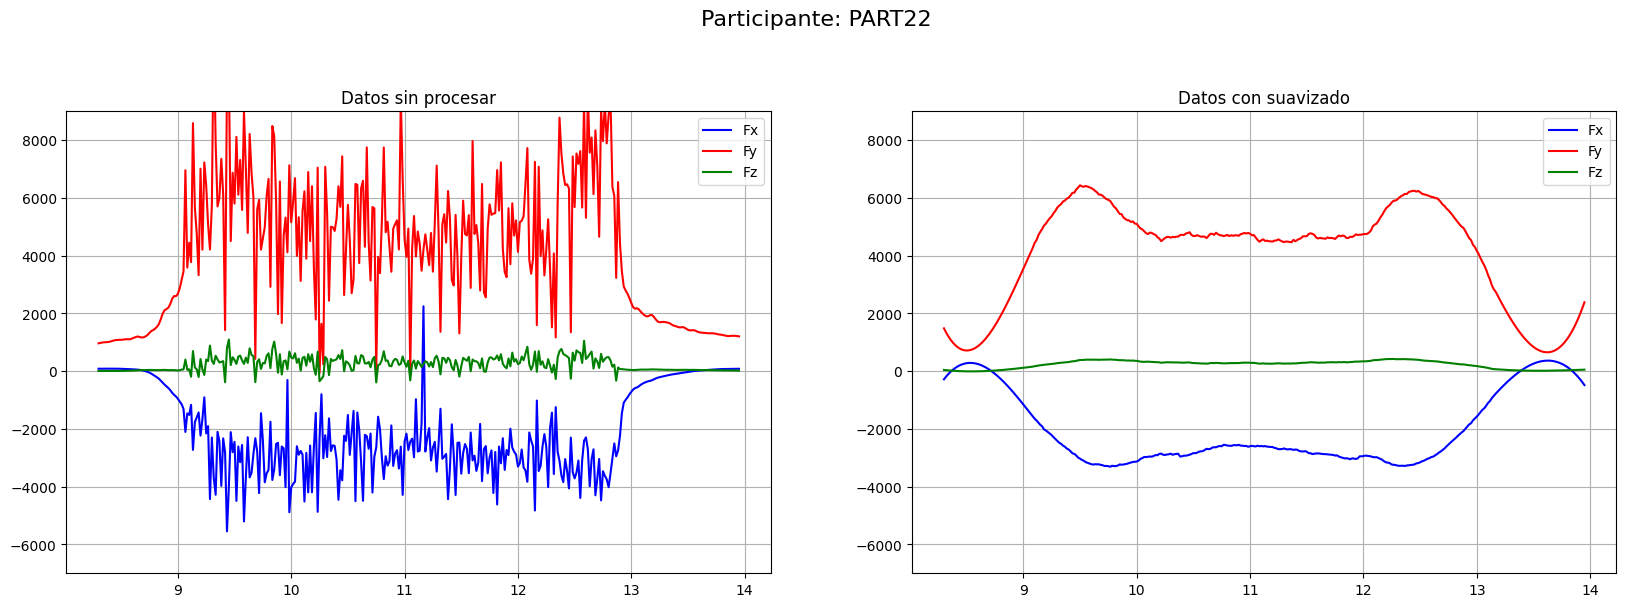

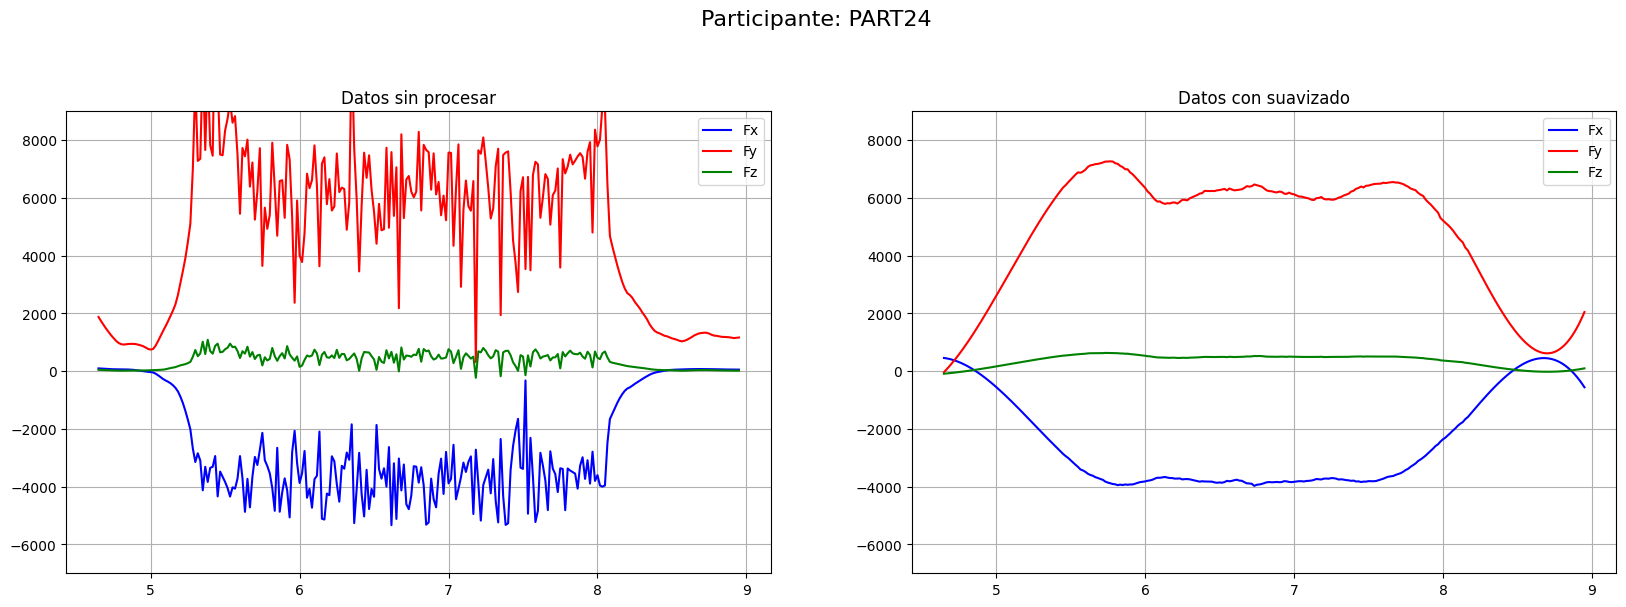

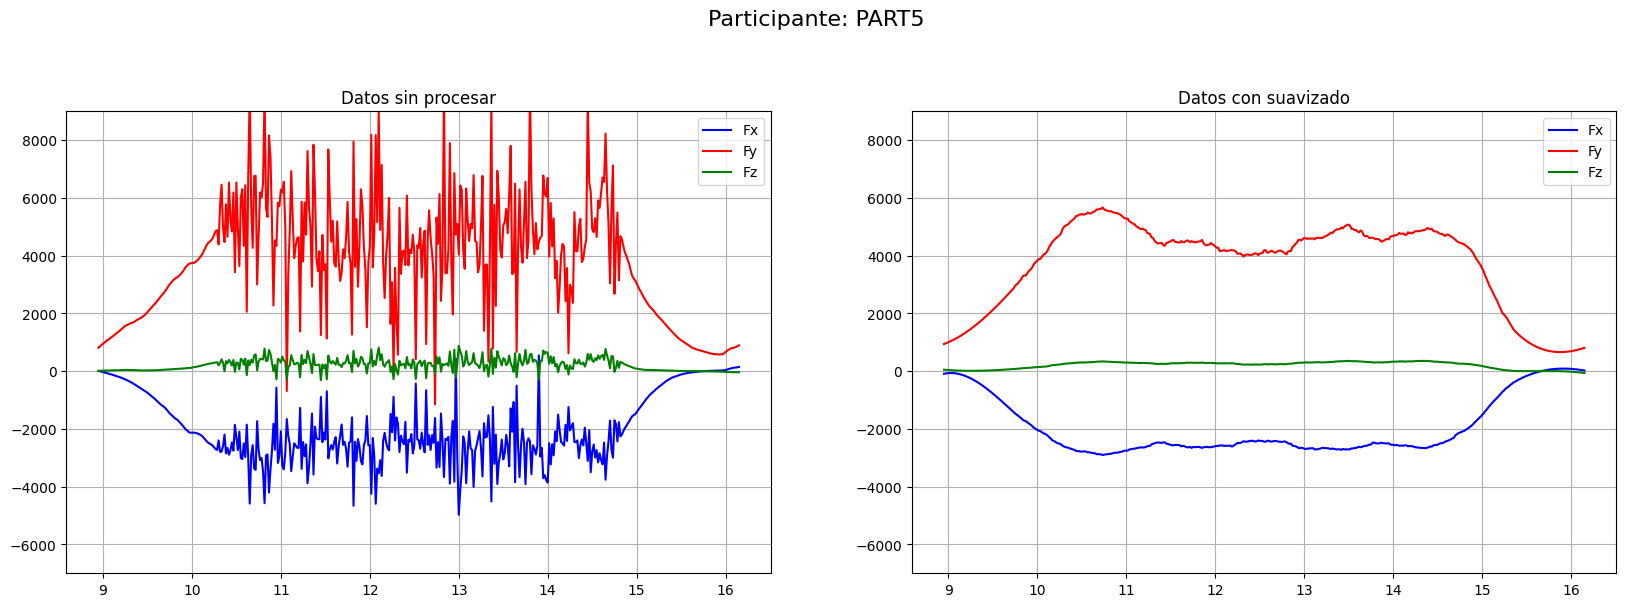

In [11]:
# plt.figure(figsize=(12,6))
for name in estructura.dtype.names:

    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    fig.suptitle(f'Participante: {name}', fontsize=16, y=1.05)

    df = estructura_df(name)

    x = df['time']
    yx = df['walker_knee_r_on_femur_r_in_tibia_r_fx']
    yy = df['walker_knee_r_on_femur_r_in_tibia_r_fy']
    yz = df['walker_knee_r_on_femur_r_in_tibia_r_fz']

    
    z = zscore(yx)
    yx_cleaned = yx.copy()
    yx_cleaned[np.abs(z) > 3] = np.mean(yx)  # Elimina valores con z-score mayor a 3
    z = zscore(yy)
    yy_cleaned = yy.copy()
    yy_cleaned[np.abs(z) > 3] = np.mean(yy)
    z = zscore(yz)
    yz_cleaned = yz.copy()
    yz_cleaned[np.abs(z) > 3] = np.mean(yz)

    ax1.plot(df['time'], yx_cleaned, label='Fx', color='blue')
    ax1.plot(df['time'], yy_cleaned, label='Fy', color='red')
    ax1.plot(df['time'], yz_cleaned, label='Fz', color='green')
    # ax1.plot(df['time'], yx, label='Fx', color='blue')
    # ax1.plot(df['time'], yy, label='Fy', color='red')
    # ax1.plot(df['time'], yz, label='Fz', color='green')
    ax1.set_ylim(-7000,9000)
    ax1.set_title('Datos sin procesar')
    ax1.grid()
    ax1.legend()

    ax2.plot(df['time'], filter_picks_savgol(yx), label='Fx', color='blue')
    ax2.plot(df['time'], savgol_filter(yy_cleaned, window_length=95, polyorder=3), label='Fy', color='red')
    ax2.plot(df['time'], savgol_filter(yz_cleaned, window_length=95, polyorder=3), label='Fz', color='green')
    ax2.set_ylim(-7000,9000)
    ax2.set_title('Datos con suavizado')
    ax2.grid()
    ax2.legend()


    plt.show()


C:\Users\Diego Alejandro\AppData\Local\Temp\ipykernel_12924\2740061452.py:3: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(time, signal, grado)          # Encuentra los coeficientes del polinomio


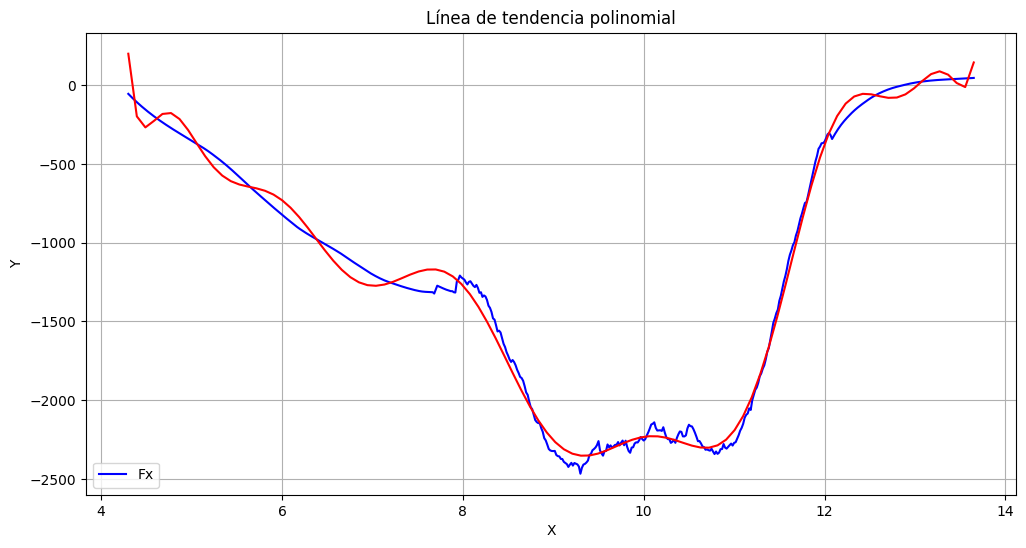

In [130]:
def tendencia(time,signal,grado = 15):
    x = time
    coef = np.polyfit(time, signal, grado)          # Encuentra los coeficientes del polinomio
    polinomio = np.poly1d(coef)             # Crea el polinomio
    x_fit = np.linspace(time.min(), time.max(), 100)
    y_fit = polinomio(x_fit)   
    return x_fit,y_fit

x_fit,y_fit = tendencia(df['time'], df['walker_knee_r_on_femur_r_in_tibia_r_fx'])

plt.figure(figsize=(12,6))
# Dibuja la línea de tendencia
plt.plot(df['time'], savgol_filter(yx, window_length=95, polyorder=3), label='Fx', color='blue')
plt.plot(x_fit, y_fit, color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Línea de tendencia polinomial')
plt.legend()
plt.grid(True)
plt.show()